In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import timm
from tqdm import tqdm

#Random Seed
import torch
torch.manual_seed(42)
import random
random.seed(42)
np.random.seed(42)

In [2]:
#Create Dataloader and Transforms

#Labels

'''
Severity Levels

0 - 'No_DR',
1 - 'Mild',
2 - 'Moderate',
3 - 'Severe',
4 - 'Proliferate_DR'
'''

class_mapping = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

#Dataloader
class DRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_mapping = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        diagnosis = self.data.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, self.class_mapping[diagnosis], f"{img_name}.png")

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, diagnosis

In [3]:
# # Define separate transformations for training and validation (Maybe later with complex ones, Start with Simple)
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# val_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Define train and val transformations

train_transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
#Creating DataSplits for Visualization
#(For Visualization Only)

train_transform_viz = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_transform_viz = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

from google.colab import drive
drive.mount('/content/drive')

# Create full dataset without transforms
csv_file = "/content/drive/MyDrive/train.csv"
img_dir = "/content/drive/MyDrive/gaussian_filtered_images"
full_dataset = DRDataset(csv_file=csv_file,
                         img_dir=img_dir,
                         transform=None)

Mounted at /content/drive


In [5]:
# Create train/validation split
train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.data['diagnosis']
)

# Create train and validation datasets with separate transforms
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transform_viz)
val_dataset = TransformedSubset(val_dataset, val_transform_viz)



In [14]:
#Visualization
#Visualize some samples

# Function to visualize samples
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(len(dataset.subset.dataset.class_mapping), num_samples, figsize=(20, 15))
    for i, class_name in enumerate(dataset.subset.dataset.class_mapping):
        class_indices = [idx for idx in range(len(dataset)) if dataset[idx][1] == i]
        samples = np.random.choice(class_indices, num_samples, replace=False)
        for j, sample_idx in enumerate(samples):
            img, _ = dataset[sample_idx]
            img = img.permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(class_name, rotation=90, va='center')
    plt.tight_layout()
    plt.show()

# Visualize samples from training set
print("Samples from Training Set:")
visualize_samples(train_dataset)

# Visualize samples from validation set
print("Samples from Validation Set:")
visualize_samples(val_dataset)



Output hidden; open in https://colab.research.google.com to view.

In [15]:
#Information
#How many samples in validation set and training set

# Function to plot class distribution
def plot_class_distribution(dataset, title):
    class_counts = [0] * len(dataset.subset.dataset.class_mapping)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(dataset.subset.dataset.class_mapping, class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

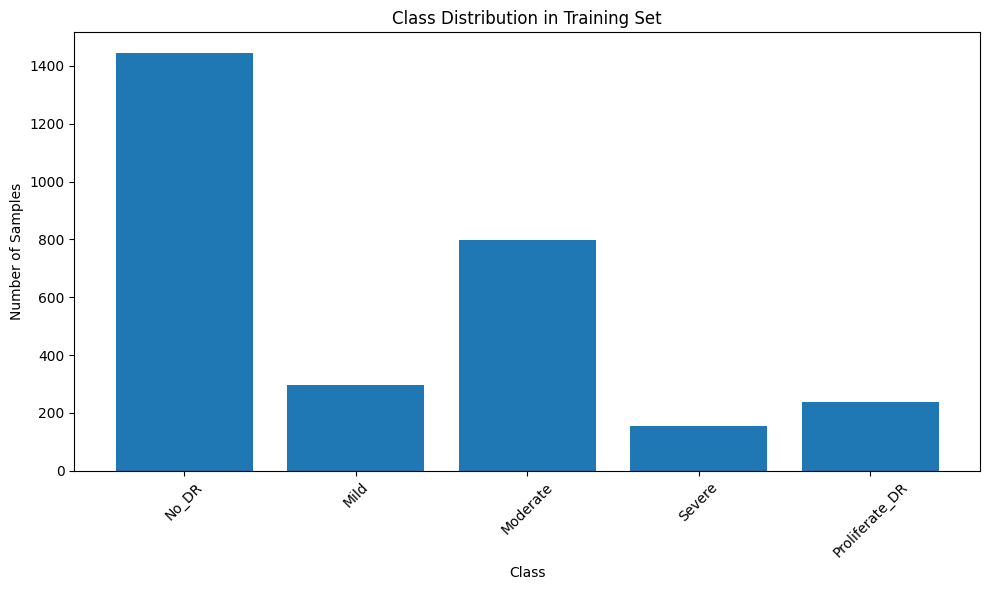

In [16]:
# Plot class distribution for training set
plot_class_distribution(train_dataset, "Class Distribution in Training Set")

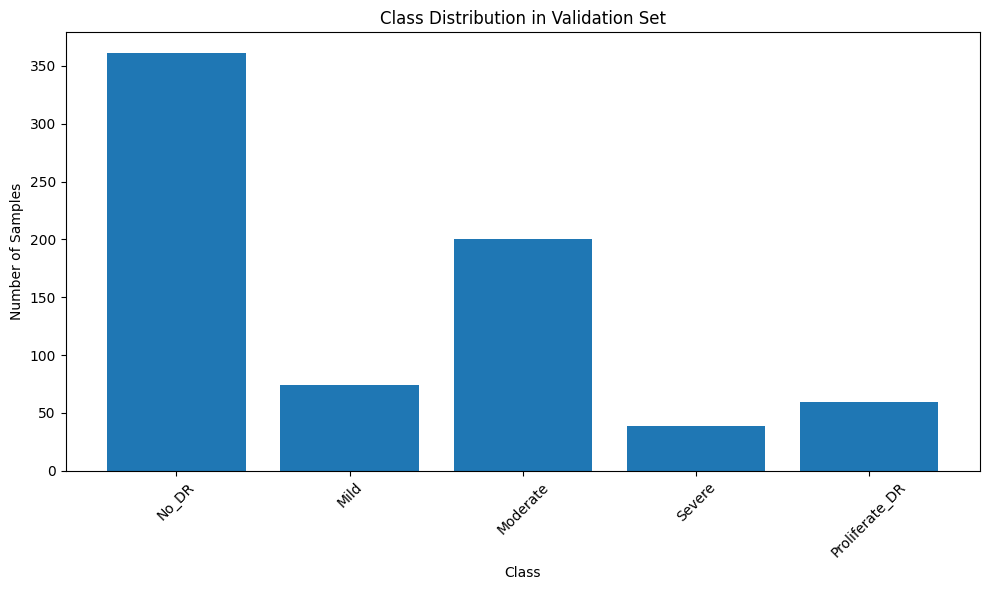

In [17]:
# Plot class distribution for validation set
plot_class_distribution(val_dataset, "Class Distribution in Validation Set")

In [8]:
#Creating DataSplits for Training and Validation


# Create full dataset without transforms
csv_file = "/content/drive/MyDrive/train.csv"
img_dir = "/content/drive/MyDrive/gaussian_filtered_images"
full_dataset = DRDataset(csv_file=csv_file,
                         img_dir=img_dir,
                         transform=None)


# Create train/validation split
train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.data['diagnosis']
)

# Create train and validation datasets with separate transforms
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transform)
val_dataset = TransformedSubset(val_dataset, val_transform)

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Example usage
print("Training Data:")
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    break

print("\nValidation Data:")
for images, labels in val_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    break

Training Data:
Batch shape: torch.Size([256, 3, 224, 224])
Labels: tensor([0, 2, 3, 0, 0, 2, 3, 0, 1, 0, 4, 4, 0, 0, 4, 0, 3, 3, 0, 2, 2, 2, 0, 2,
        4, 0, 2, 0, 0, 0, 2, 4, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
        4, 2, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0, 1, 4, 0, 1, 2, 2, 4, 2, 0, 2, 0, 0,
        0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2,
        3, 3, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 3, 0, 2, 3, 0, 0, 0, 0, 0,
        2, 0, 1, 0, 0, 0, 0, 0, 2, 3, 2, 3, 4, 3, 4, 2, 0, 2, 4, 0, 1, 1, 1, 4,
        0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 1, 0, 3, 3, 0, 0, 0,
        2, 4, 1, 0, 3, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 2, 0, 0, 2,
        2, 0, 4, 0, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 3, 0, 2, 0, 1,
        0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 4, 2, 0, 2, 2, 0, 3, 2, 4, 4, 3, 2,
        4, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0])

Validation Data:
Batch shape: torch.Size([256, 3, 224, 224])
Labels: tensor

In [9]:
# Define hyperparameters
num_epochs = 30
#Generally 0.001 for SGD and 0.001 for Adam for less epochs of 30
#Otherwise 0.003 for SGD and 0.0003 for Adam if we go up to 50 (Remember the magic days)
initial_lr = 0.001
num_classes = 5  # Assuming 5 classes


#Model Declaration (Try out Different Models)
model_name = 'tiny_vit_11m_224.dist_in22k_ft_in1k'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

#Optimizer and Loss function
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

#Tryout Different Optimizers
#optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
#1e-2
#optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-2)

# Learning rate scheduler (Various Try)
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=initial_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,25], gamma=0.1, last_epoch=-1, verbose='deprecated')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/44.1M [00:00<?, ?B/s]

In [10]:
#Visualize Some Correct and Wrong Samples
#And Save Confusion Matrix


# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

# Training and validation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_f1 = 0
history = {
    'train_loss': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'train_accuracy': [],
    'val_loss': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_accuracy': []
}

In [11]:
#Train and Validation Loop

#Save best model
#Save (Training and Validation) Loss, Precision, Recall and F1-Score every epoch and plot

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []

    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(targets.cpu().numpy())

    train_loss /= len(train_loader)
    train_precision, train_recall, train_f1, train_accuracy = calculate_metrics(train_targets, train_preds)

    scheduler.step()


    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_precision, val_recall, val_f1, val_accuracy = calculate_metrics(val_targets, val_preds)

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), model_name + "_" + 'best_model.pth')

    # Record history
    history['train_loss'].append(train_loss)
    history['train_precision'].append(train_precision)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    history['val_accuracy'].append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/30 - Validation: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30:
Train Loss: 1.0852, Train F1: 0.5471, Train Accuracy: 0.6033
Val Loss: 0.8660, Val F1: 0.6244, Val Accuracy: 0.6903


Epoch 2/30 - Training: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 2/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30:
Train Loss: 0.7609, Train F1: 0.6939, Train Accuracy: 0.7532
Val Loss: 0.7249, Val F1: 0.6920, Val Accuracy: 0.7435


Epoch 3/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/30:
Train Loss: 0.6573, Train F1: 0.7210, Train Accuracy: 0.7682
Val Loss: 0.6477, Val F1: 0.7109, Val Accuracy: 0.7599


Epoch 4/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/30:
Train Loss: 0.5823, Train F1: 0.7567, Train Accuracy: 0.7880
Val Loss: 0.6191, Val F1: 0.7322, Val Accuracy: 0.7749


Epoch 5/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 5/30:
Train Loss: 0.5304, Train F1: 0.7782, Train Accuracy: 0.8020
Val Loss: 0.5718, Val F1: 0.7422, Val Accuracy: 0.7817


Epoch 6/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/30:
Train Loss: 0.4679, Train F1: 0.8186, Train Accuracy: 0.8324
Val Loss: 0.6285, Val F1: 0.7697, Val Accuracy: 0.7954


Epoch 7/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 7/30:
Train Loss: 0.4329, Train F1: 0.8348, Train Accuracy: 0.8467
Val Loss: 0.6510, Val F1: 0.7617, Val Accuracy: 0.7844


Epoch 8/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 8/30:
Train Loss: 0.3899, Train F1: 0.8456, Train Accuracy: 0.8569
Val Loss: 0.7446, Val F1: 0.7508, Val Accuracy: 0.7694


Epoch 9/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 9/30:
Train Loss: 0.3291, Train F1: 0.8758, Train Accuracy: 0.8815
Val Loss: 0.7386, Val F1: 0.7536, Val Accuracy: 0.7531


Epoch 10/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 10/30:
Train Loss: 0.2822, Train F1: 0.8968, Train Accuracy: 0.8996
Val Loss: 0.7037, Val F1: 0.7819, Val Accuracy: 0.8035


Epoch 11/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Epoch 11/30:
Train Loss: 0.2251, Train F1: 0.9190, Train Accuracy: 0.9211
Val Loss: 0.7968, Val F1: 0.7560, Val Accuracy: 0.7558


Epoch 12/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch 12/30:
Train Loss: 0.2303, Train F1: 0.9151, Train Accuracy: 0.9181
Val Loss: 1.0211, Val F1: 0.7129, Val Accuracy: 0.6971


Epoch 13/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch 13/30:
Train Loss: 0.1994, Train F1: 0.9311, Train Accuracy: 0.9314
Val Loss: 1.1348, Val F1: 0.6870, Val Accuracy: 0.6712


Epoch 14/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 14/30:
Train Loss: 0.1486, Train F1: 0.9539, Train Accuracy: 0.9543
Val Loss: 0.9483, Val F1: 0.7830, Val Accuracy: 0.8035


Epoch 15/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 15/30:
Train Loss: 0.1458, Train F1: 0.9536, Train Accuracy: 0.9539
Val Loss: 0.9524, Val F1: 0.7698, Val Accuracy: 0.7613


Epoch 16/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 16/30:
Train Loss: 0.1315, Train F1: 0.9564, Train Accuracy: 0.9566
Val Loss: 0.8308, Val F1: 0.8005, Val Accuracy: 0.8131


Epoch 17/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 17/30:
Train Loss: 0.1125, Train F1: 0.9639, Train Accuracy: 0.9642
Val Loss: 0.9883, Val F1: 0.7661, Val Accuracy: 0.7531


Epoch 18/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 18/30:
Train Loss: 0.1167, Train F1: 0.9612, Train Accuracy: 0.9614
Val Loss: 0.9782, Val F1: 0.7702, Val Accuracy: 0.7667


Epoch 19/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch 19/30:
Train Loss: 0.1136, Train F1: 0.9650, Train Accuracy: 0.9652
Val Loss: 0.9618, Val F1: 0.7943, Val Accuracy: 0.8076


Epoch 20/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 20/30:
Train Loss: 0.1103, Train F1: 0.9669, Train Accuracy: 0.9669
Val Loss: 1.0692, Val F1: 0.7621, Val Accuracy: 0.7763


Epoch 21/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Epoch 21/30:
Train Loss: 0.0925, Train F1: 0.9711, Train Accuracy: 0.9713
Val Loss: 0.9533, Val F1: 0.7868, Val Accuracy: 0.7967


Epoch 22/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 22/30:
Train Loss: 0.0701, Train F1: 0.9770, Train Accuracy: 0.9771
Val Loss: 0.9276, Val F1: 0.7921, Val Accuracy: 0.7995


Epoch 23/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch 23/30:
Train Loss: 0.0567, Train F1: 0.9826, Train Accuracy: 0.9826
Val Loss: 0.9249, Val F1: 0.7938, Val Accuracy: 0.7981


Epoch 24/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 24/30:
Train Loss: 0.0575, Train F1: 0.9819, Train Accuracy: 0.9819
Val Loss: 0.9278, Val F1: 0.7997, Val Accuracy: 0.8049


Epoch 25/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch 25/30:
Train Loss: 0.0434, Train F1: 0.9863, Train Accuracy: 0.9863
Val Loss: 0.9379, Val F1: 0.7930, Val Accuracy: 0.7967


Epoch 26/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Epoch 26/30:
Train Loss: 0.0492, Train F1: 0.9853, Train Accuracy: 0.9853
Val Loss: 0.9405, Val F1: 0.7957, Val Accuracy: 0.8008


Epoch 27/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


Epoch 27/30:
Train Loss: 0.0539, Train F1: 0.9822, Train Accuracy: 0.9822
Val Loss: 0.9424, Val F1: 0.7968, Val Accuracy: 0.8022


Epoch 28/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


Epoch 28/30:
Train Loss: 0.0525, Train F1: 0.9836, Train Accuracy: 0.9836
Val Loss: 0.9471, Val F1: 0.7935, Val Accuracy: 0.7995


Epoch 29/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


Epoch 29/30:
Train Loss: 0.0536, Train F1: 0.9832, Train Accuracy: 0.9833
Val Loss: 0.9506, Val F1: 0.7955, Val Accuracy: 0.8022


Epoch 30/30 - Validation: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch 30/30:
Train Loss: 0.0453, Train F1: 0.9843, Train Accuracy: 0.9843
Val Loss: 0.9497, Val F1: 0.7948, Val Accuracy: 0.8008


In [12]:
# Plot training history
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history['train_precision'], label='Train Precision')
plt.plot(history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.savefig(model_name + "_" + 'training_history.png')
plt.close()

# Print best validation F1 score
print(f'Best Validation F1 Score: {best_f1:.4f}')

# Plot confusion matrices
plot_confusion_matrix(train_targets, train_preds, model_name + "_" + 'Training Confusion Matrix')
plot_confusion_matrix(val_targets, val_preds, model_name + "_" + 'Validation Confusion Matrix')


Best Validation F1 Score: 0.8005


In [13]:
# Final evaluation on test set
model.load_state_dict(torch.load(model_name + "_" + 'best_model.pth'))
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc='Final Evaluation'):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_precision, test_recall, test_f1, test_accuracy = calculate_metrics(test_targets, test_preds)
print(f'Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

plot_confusion_matrix(test_targets, test_preds, model_name + "_" + 'Test Confusion Matrix')

<ipython-input-13-0f296b96e72e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name + "_" + 'best_model.pth'))
Final Evaluation: 100

Test F1: 0.7989, Test Accuracy: 0.8117
